# ROSAT All-Sky Survey (X-ray) Recreation

![](https://heasarc.gsfc.nasa.gov/Images/rosat/slide_gifs/misc_rass.gif)

In this python notebook, we will reproduce the image above. It's a colorized composite of data from the ROSAT All-Sky Survey available from NASA here: https://heasarc.gsfc.nasa.gov/docs/rosat/gallery/misc_allsky1.html. The ROSAT was launched 30 years ago on the day of this writing. Its observations were completed in 1990-1991 and were composited at a low resolution. The [high resolution TIF format version](https://heasarc.gsfc.nasa.gov/Images/rosat/slide_gifs/misc_rass.tif) is only 1633x815 pixels.

The image we're trying to replicate was published in _[M.J.Freyberg, R.Egger (1999), "ROSAT PSPC All-Sky Survey maps completed", in Proceedings of the Symposium "Highlights in X-ray Astronomy in honour of Joachim Trümper's 65th birthday", eds. B.Aschenbach & M.J.Freyberg, MPE Report 272, p.278-281, Fig.4.](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?bibcode=1999hxra.conf..278F&db_key=AST&page_ind=3&data_type=GIF&type=SCREEN_VIEW&classic=YES)_

The image is labeled `red: 0.1-0.4 keV  green: 0.5-0.9 keV  blue: 0.9-2.0 keV` and it's caption reads:

> "3-colour composite image of a 100° x 100° region centered on l = 0°, b = 0° created from the completed maps. The 1/4keV band emission is coded red, green denotes 3/4keV band emission, and blue represents the hard 1.5keV band. Prominent features are Sco X-1 (the hard source in the upper third of the image) and its bright X-ray scattering halo (note, that the central ~30' remained still unobserved)."

In [15]:
# First we'll import some libraries we'll be using to request and modify our data

# For working with astronomical data
# https://docs.astropy.org/en/stable/
# https://astroquery.readthedocs.io/en/latest/
from astropy import units as u
from astroquery.skyview import SkyView
from astropy.visualization import (PercentileInterval,
                                   AsinhStretch, CompositeStretch, ContrastBiasStretch, HistEqStretch, LinearStretch, 
                                   LogStretch, PowerDistStretch, PowerStretch, SinhStretch, SqrtStretch, SquaredStretch)

# For graphs, data, and image processing
from matplotlib import colors, pyplot as plt
from scipy import ndimage
import numpy as np
import imageio

## SkyView  

NASA's incredible [SkyView](https://skyview.gsfc.nasa.gov/current/cgi/titlepage.pl) website gives the public access to loads of astronomical observations, including the one we're interested in. The ROSAT satellite observed the entire sky in x-ray wavelengths. First, let's see which ROSAT observations are available from Skyview. Surveys are listed on the SkyView website [here](https://skyview.gsfc.nasa.gov/current/cgi/survey.pl) and can also be queried via `astroquery.skyview`.

In [16]:
# https://astroquery.readthedocs.io/en/latest/api/astroquery.skyview.SkyViewClass.html#astroquery.skyview.SkyViewClass.list_surveys
SkyView.list_surveys()

{'Allbands:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                            'GOODS: Chandra ACIS FB',
                            'GOODS: Chandra ACIS SB',
                            'GOODS: VLT VIMOS U',
                            'GOODS: VLT VIMOS R',
                            'GOODS: HST ACS B',
                            'GOODS: HST ACS V',
                            'GOODS: HST ACS I',
                            'GOODS: HST ACS Z',
                            'Hawaii HDF U',
                            'Hawaii HDF B',
                            'Hawaii HDF V0201',
                            'Hawaii HDF V0401',
                            'Hawaii HDF R',
                            'Hawaii HDF I',
                            'Hawaii HDF z',
                            'Hawaii HDF HK',
                            'GOODS: HST NICMOS',
                            'GOODS: VLT ISAAC J',
                            'GOODS: VLT ISAAC H',
                            'GOODS: 

For this recreation, we'll select from the 7 energy bands of the [ROSAT All-Sky X-ray Background Survey](https://skyview.gsfc.nasa.gov/current/cgi/survey.pl#ROSAT%20All-Sky%20X-ray%20Background%20Survey:%20Band%201) and try to grab energy bands close to the image described above. The available bands are:

| Band   | Energy range (keV) |
|--------|--------------------|
| Band 1 | 0.11 - 0.284       |
| Band 2 | 0.14 - 0.284       |
| Band 3 | 0.2  - 0.83        |
| Band 4 | 0.44 - 1.01        |
| Band 5 | 0.56 - 1.21        |
| Band 6 | 0.73 - 1.56        |
| Band 7 | 1.05 - 2.04        |

In [17]:
# The survey's pixel scale is 0.2 degrees / pixel
# meaning a full 360° x 180° would be 1800 x 900 pixels
# But those "pixels" may be in a different projection
# so let's oversample:
w=4800
h=2400

# Request image data from Skyview
# see: https://astroquery.readthedocs.io/en/latest/api/astroquery.skyview.SkyViewClass.html#astroquery.skyview.SkyViewClass.get_images
r, g, b = SkyView.get_images(
    
    # Selecting lowest, middle, and highest bands
    survey=['RASS Background 1','RASS Background 4','RASS Background 7'],
    
    # Center the image
    position='0,0',
    
    # In Galactic coordinates, so that the milky way will be in the middle
    coordinates='Galactic', 
    
    # The original data was in the projection "Zenithal Equal Area (Zea)" 
    # But our target image was in "Hammer-Aitoff (Ait)""
    # If you're using something like Three.js https://threejs.org/examples/webgl_panorama_equirectangular.html
    # you may want to use "Rectangular (Car)"
    projection='Ait',
    #projection='Zea',
    #projection='Car',
    
    # The resolution of our requested images
    pixels=f'{w},{h}',
    
    # The entire sky, 360° by 180° 
    width=(360*u.deg), # right ascension
    height=(180*u.deg) # declination

)

## Data Analysis and Normalization

`SkyView.get_images` returns a list of [HDUList Objects](https://docs.astropy.org/en/stable/io/fits/api/hdulists.html#astropy.io.fits.HDUList), one for each survey we requested, which we've loaded into `r`, `g`, and `b` for the colors we're going to assign them in our image. First, let's use `pyplot` to analyze the data we received.

min:-390.625 max:50290.06640625


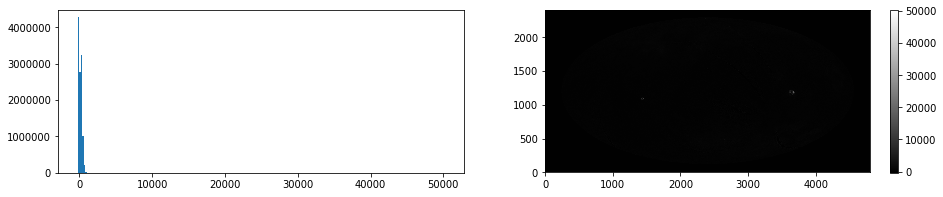

In [18]:
# Red channel
rData = r[0].data

# min and max values in data
print(f'min:{rData.min()} max:{rData.max()}')

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16.0,3.0)

# histogram of values
# excluding 0 here because it's a huge spike
ax[0].hist(rData.ravel(), bins=256)

# display image
map = ax[1].imshow(rData,cmap="gray",origin="lower")
fig.colorbar(map)

# More on using matplotlib for image analysis and manipulation here:
# https://matplotlib.org/3.2.1/tutorials/introductory/images.html#examining-a-specific-data-range

The data we received ranges from negative values into the positive tens of thousands. When we try to plot it, the huge values completely obscure the details in the lower range. We'll need to normalize those values to between 0 and 1 before we can generate our image. The `matplotlib` library has some great [normalization features](https://matplotlib.org/3.2.1/tutorials/colors/colormapnorms.html). Below we can see that even just truncating our values between a `vmin` and `vmax` get's us more detail.

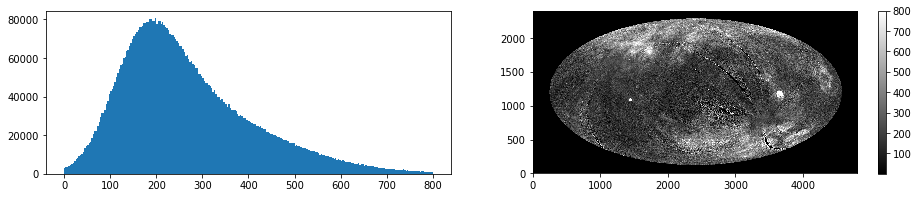

In [19]:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
# https://matplotlib.org/3.2.1/tutorials/introductory/images.html#examining-a-specific-data-range
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16.0,3.0)
ax[0].hist(rData.ravel(), bins=256, range=(0.001,800))
map = ax[1].imshow(rData,cmap="gray",origin="lower",vmin=0.001,vmax=800)
fig.colorbar(map)

As seen above, honing in on a range from 0.001 to 800 gives us most of the detail we want. But this is an arbitrary range. The histogram and image look good, but we can be a bit more systematic about the data we select by using `astropy`'s [image normalization](https://docs.astropy.org/en/stable/visualization/normalization.html) capabilities. Normalization scales our data within the range from 0 to 1. As it does so, we can tell it to use a specific strategy. Since the histogram above has long tails of values on either side of the peak, we can use the `PercentileInterval` strategy to keep 99% of the data pixels and trim outliers with very high and very low values. This dials in the range to where there's meaningful detail and discards the rest.

## Digression: Stretching

After normalization, if we really wanted to fine tune our colorization of this data we could use `astropy`'s [image stretching](https://docs.astropy.org/en/stable/visualization/normalization.html#stretching). Stretching lets us boost the details we want to focus on in that range. You can think of this step as adjusting brightness and contrast. But we've got a lot of subtle options. Let's visualize what some of these stretching functions do. Each of our pixels can have a value from 0 to 1. Stretching functions convert each pixel to a new value based on its existing value. If we plot existing values on the x axis and stretched values on the y axis, we can see how each function stretches our values.

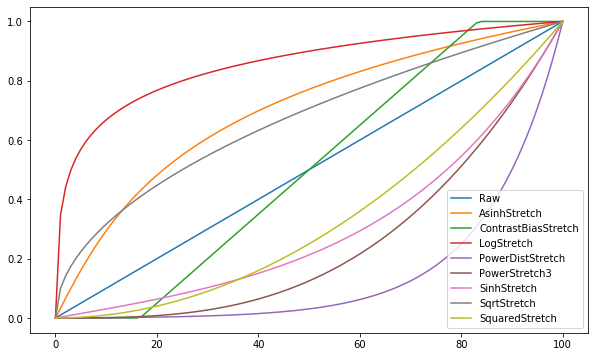

In [20]:
linear_sequence = np.arange(0.0,1.01,0.01)
fig, ax = plt.subplots()
fig.set_size_inches(10.0,6.0)

# astropy's stretching functions
# https://docs.astropy.org/en/stable/visualization/normalization.html
# https://docs.astropy.org/en/stable/visualization/
ax.plot(linear_sequence, label='Raw')
ax.plot(AsinhStretch(a=0.1)(linear_sequence), label='AsinhStretch')
ax.plot(ContrastBiasStretch(1.5,.5)(linear_sequence), label='ContrastBiasStretch')
ax.plot(LogStretch()(linear_sequence), label='LogStretch')
ax.plot(PowerDistStretch()(linear_sequence), label='PowerDistStretch')
ax.plot(PowerStretch(3)(linear_sequence), label='PowerStretch3')
ax.plot(SinhStretch()(linear_sequence), label='SinhStretch')
ax.plot(SqrtStretch()(linear_sequence), label='SqrtStretch')
ax.plot(SquaredStretch()(linear_sequence), label='SquaredStretch')
ax.legend()

## Prepare Energy Bands as Color Channels

Ok, back to the task at hand. Let's go through each of our energy bands, apply the `PercentileInterval` to normalize 99% of our data, and display the band in its intended color channel. We'll also add a bit of Gaussian blur to the data. We're sacrificing some data purity in doing so, but this will help the color channels blend better visually in areas where the survey has lots of single pixels.

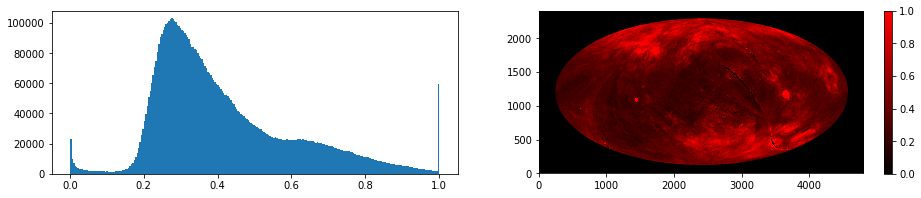

In [21]:
data = r[0].data

# blur the data a bit so it's easier on the eyes 
# (with apologies to my purist friends)
data = ndimage.gaussian_filter(data, sigma=4)

# normalize using percentile interval
data = PercentileInterval(99.)(data)

# plot histogram and image
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16.0,3.0)
ax[0].hist(data.ravel(), bins=256, range=(0.001, 1.0))

# create color map
# https://matplotlib.org/tutorials/colors/colormaps.html
# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('k2r',['k','#ff0000'])

map = ax[1].imshow(data,cmap=cmap,origin='lower')
fig.colorbar(map)

rCmap = cmap
rData = data

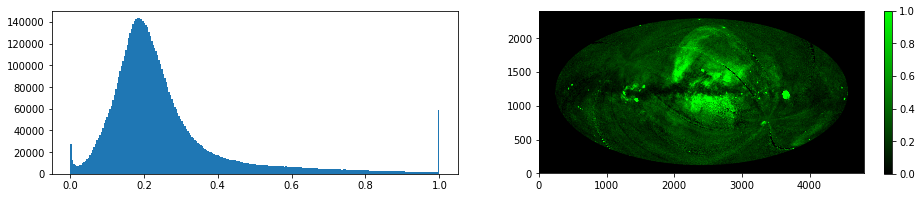

In [22]:
data = g[0].data

# blur
data = ndimage.gaussian_filter(data, sigma=4)

# normalize
data = PercentileInterval(99.)(data)

# plot
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16.0,3.0)
ax[0].hist(data.ravel(), bins=256, range=(0.001, 1.0))

# create color map
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('k2g',['k','#00ff00'])

map = ax[1].imshow(data,cmap=cmap,origin='lower')
fig.colorbar(map)

gCmap = cmap
gData = data

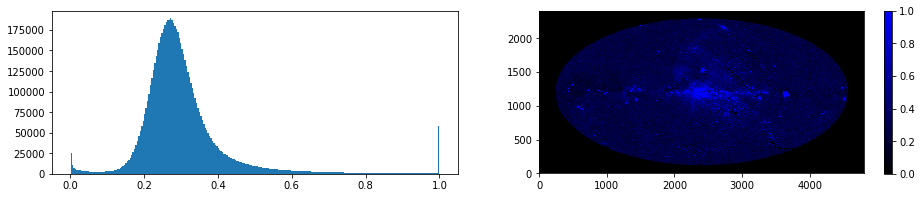

In [24]:
data = b[0].data

# blur
data = ndimage.gaussian_filter(data, sigma=4)

# normalize
data = PercentileInterval(99.)(data)

# plot
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(16.0,3.0)
ax[0].hist(data.ravel(), bins=256, range=(0.001, 1.0))

# create color map
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('k2b',['k','#0000ff'])

map = ax[1].imshow(data,cmap=cmap,origin='lower')
fig.colorbar(map)

bCmap = cmap
bData = data

## Merge Color Channels and Draw Image

Now that we have our color data in `rData`, `gData`, and `bData`, we can use `numpy` to combine them, and `pyplot` to draw the image.

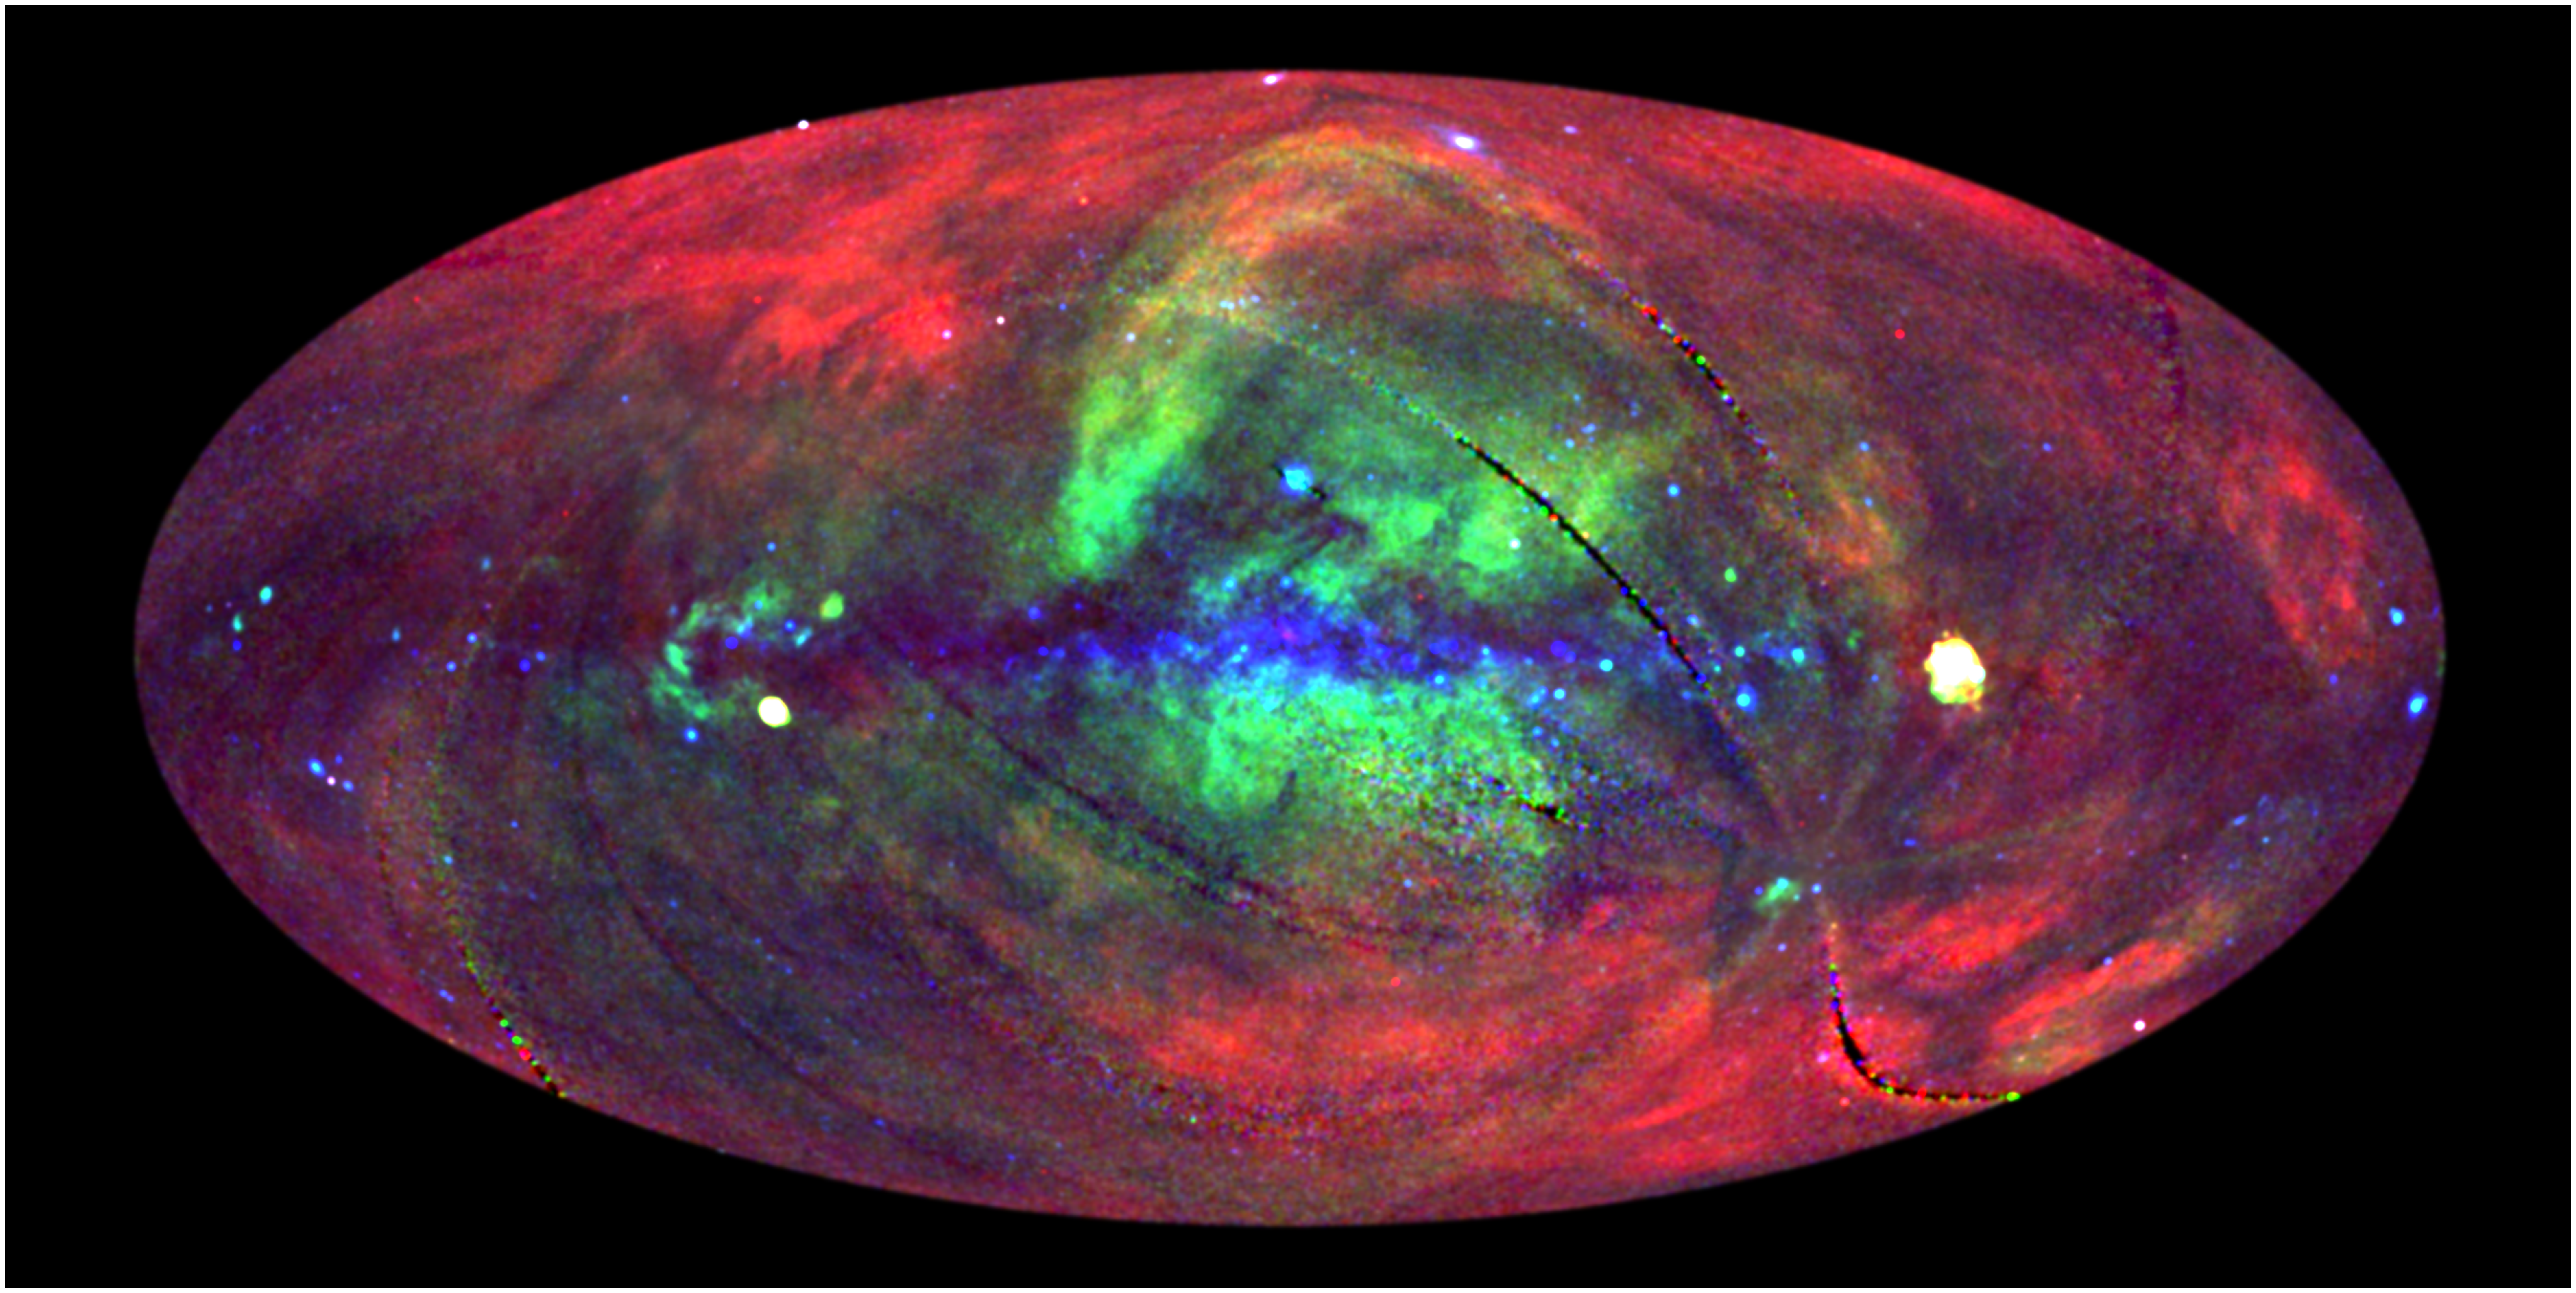

In [26]:
rgb = np.dstack((rData,gData,bData))
fig, ax = plt.subplots()
fig.set_size_inches(w/fig.dpi,h/fig.dpi)
ax.imshow(rgb,origin='lower')
ax.axis('off') 
## if you run this notebook locally, uncommenting this line will save the png
#plt.savefig('rosat.png', bbox_inches='tight', pad_inches = 0)

There we have our higher resolution reproduction of ROSAT's all-sky survey. Our beautiful x-ray sky!